In [1]:
# Import required libraries.
import numpy as np
import math
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import datetime
import yfinance as yf
from IPython.core.display import display
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from numba import njit, prange # for parallel computing
import time

NUM_TRADING_DAYS = 252 # total trading days of a year

## Load and Process the Low Correlation Stock Data

Load the CSV data for low correlation stocks created in the data collection procedure. Add an additional
column for basket prices, which is essentially the mean of previous column items in each row.

In [2]:
low_corr_stocks = ['CVX' , 'EA', 'EDU', 'TSLA']
low_corr_stocks_df = pd.read_csv('../Results/low_correlation_stocks.csv')
low_corr_stocks_df.columns = ['Date', 'CVX' , 'EA', 'EDU', 'TSLA']
low_corr_stocks_df.set_index('Date', inplace=True)
display(low_corr_stocks_df)

,CVX,EA,EDU,TSLA
Date,,,,
2018-12-31,101.839668,78.910004,54.810001,332.799988
2019-01-02,103.618286,80.370003,55.310001,310.119995
2019-01-03,101.633728,78.709999,53.950001,300.359985
2019-01-04,103.739975,84.419998,56.570000,317.690002
2019-01-07,105.087990,87.589996,58.619999,334.959991
...,...,...,...,...
2019-12-23,117.218971,107.790001,124.959999,419.220001
2019-12-24,117.228706,108.550003,124.699997,425.250000
2019-12-26,117.481995,108.510002,125.000000,430.940002


### Compute Percentage Returns

In [3]:
pct_returns_df = low_corr_stocks_df.pct_change(1).copy()
pct_returns_df['Basket'] = pct_returns_df.mean(numeric_only=True, axis=1)
W = np.array([0.25, 0.25, 0.25, 0.25])

for i in range (1, pct_returns_df.shape[0]):
    pct_returns_df.iloc[i]['Basket'] = np.dot(np.array(pct_returns_df.iloc[i].values[:4]), W)
# Compute for the last row.
display(pct_returns_df)

,CVX,EA,EDU,TSLA,Basket
Date,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN
2019-01-02,0.017465,0.018502,0.009122,-0.068149,-0.005765
2019-01-03,-0.019153,-0.020655,-0.024589,-0.031472,-0.023967
2019-01-04,0.020724,0.072545,0.048563,0.057697,0.049882
2019-01-07,0.012994,0.037550,0.036238,0.054361,0.035286
...,...,...,...,...,...
2019-12-23,0.005431,-0.001482,0.009859,0.033605,0.011853
2019-12-24,0.000083,0.007051,-0.002081,0.014384,0.004859
2019-12-26,0.002161,-0.000369,0.002406,0.013380,0.004395


### Compute volatility of the percentage returns for Basket Column

In [4]:
pct_returns_avg = pct_returns_df.mean()
basket_avg = pct_returns_avg['Basket'] * NUM_TRADING_DAYS
print(f'Average annualized percentage return of the Basket Option: {basket_avg * 100:.4f}%')

pct_returns_vol = pct_returns_df.std()
basket_vol = pct_returns_vol['Basket']
print(f'Volatility of the percentage returns of the Basket Option: {basket_vol}')

basket_sigma = basket_vol * np.sqrt(NUM_TRADING_DAYS)
print(f'Annualized volatility of the percentage returns of the Basket Option: {basket_sigma}')

Average annualized percentage return of the Basket Option: 43.6543%
Volatility of the percentage returns of the Basket Option: 0.014003438829129525
Annualized volatility of the percentage returns of the Basket Option: 0.22229769984949344


## Compute Correlations

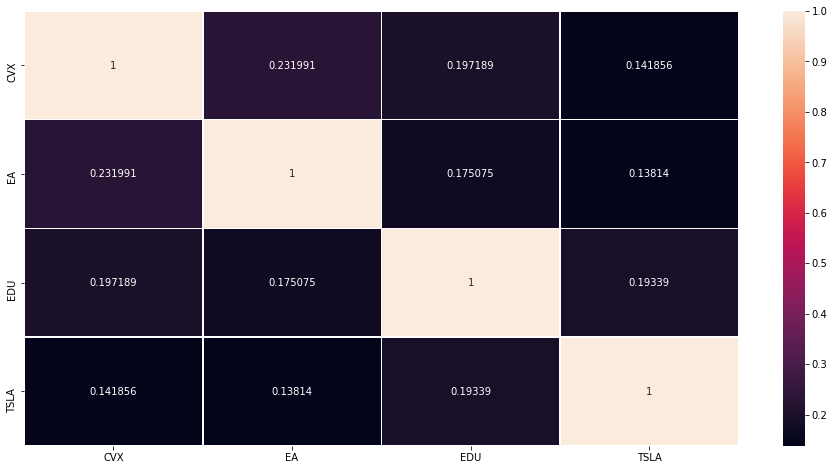

In [5]:
correlation_matrix = low_corr_stocks_df.pct_change(1).corr()
plt.figure(figsize = (16,8))
sn.heatmap(correlation_matrix, annot=True, fmt='g', linewidths=.5)
plt.show()

It can be easily seen that the selected stocks are loosely correlated.

## Perform Cholesky Decomposition

References:
1. https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy/
2. https://en.wikipedia.org/wiki/Cholesky_decomposition

Cholesky Decomposition comes handy when we need to generate correlated random numbers during Monte Carlo Simulation, the basic assumption of Cholesky Decomposition is that the (correlation) matrix is *Hermitian* and *Positive-Definite*, to compute Cholesky Decomposition of our correlation matrix, here we will use the **Cholesky-Banachiewicz Algorithm**. Specifically, for a Hermitian and Positive-Definite matrix **A**,

$$\mathbf{A} = \mathbf{L}\mathbf{U} = \mathbf{L}\mathbf{L^T} = \begin{bmatrix}&L_{11}, &0, &0\\&L_{21}, &L_{22}, &0\\&L_{31}, &L_{32}, &L_{33}\end{bmatrix}\begin{bmatrix}&L_{11}, &L_{21}, &L_{31}\\&0, &L_{22}, &L_{32}\\&0, &0, &L_{33}\end{bmatrix}$$

Then we have, by solving the LU-Decomposition of the matrix, the lower-triangular matrix $\mathbf{L}$ is,
$$\mathbf{L} = \begin{bmatrix}
&\sqrt{A_{11}}, &0,                              &0\\
&A_{21}/L_{11}, &\sqrt{A_{22} - L_{21}^2},       &0\\
&A_{31}/L_{11}, &(A_{32} - L_{31}L_{21})/L_{22}, &\sqrt{A_{33} - L_{31}^2 - L_{21}^2}
\end{bmatrix}$$

Hence, we have, for the diagonal elements of $\mathbf{L}$,
$$L_{j, j} = \pm \sqrt{A_{j,j} - \Sigma_{k=1}^{j-1}L_{j,k}^2}$$
Which is always positive if $\mathbf{A}$ is real and positive-definite, and the non-diagonal elements,
$$L_{i,j} = \frac{1}{L_{j,j}}\left(A_{i,j} - \Sigma_{k=1}^{j-1}L_{i,k}L_{j,k}\right), i > j$$

In [6]:
def cholesky_decomp(A):
    """Performs a Cholesky decomposition of A, which must 
    be a symmetric and positive definite matrix. The function
    returns the lower variant triangular matrix, L."""
    
    n = len(A)

    # Initialize a zero matrix for L.
    L = np.zeros(A.shape)

    # Perform the Cholesky decomposition
    for j in range(n):
        for i in range(j, n):
            symmetric_sum = sum(L[i][k] * L[j][k] for k in range(i))
            
            if (j == i): # Diagonal elements
                L[j][j] = np.sqrt(A[j][j] - symmetric_sum)
            else:
                # Non-diagonal elements
                L[i][j] = (1.0 / L[j][j] * (A[i][j] - symmetric_sum))
    return L

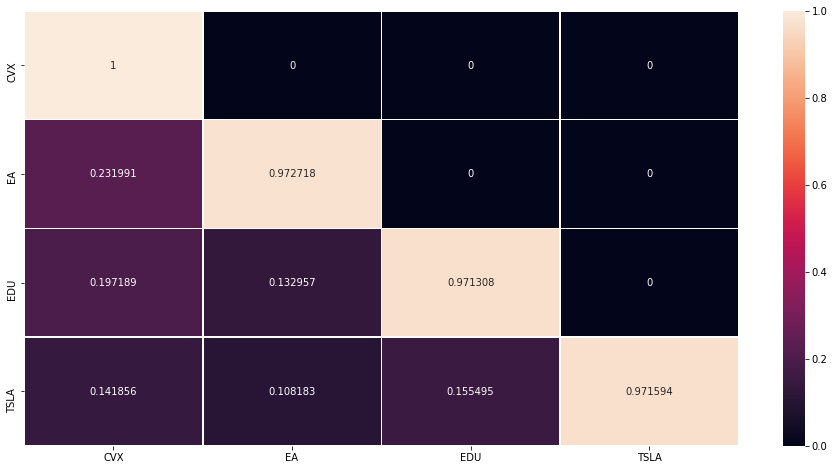

In [7]:
L = cholesky_decomp(correlation_matrix.values)
plt.figure(figsize = (16,8))
sn.heatmap(L, annot=True, fmt='g', linewidths=.5, xticklabels=low_corr_stocks, yticklabels=low_corr_stocks)
plt.show()

In [8]:
# Spot prices on August 4th, 2020
current_date = datetime.now().strftime('%Y-%m-%d')
print(current_date)
# Update with current date correspondingly.
spot_df = pd.DataFrame(yf.download('CVX EA EDU TSLA', start='2020-08-04', end='2020-08-05', progress=False)['Close'].iloc[-1])

2020-08-06


In [9]:
display(spot_df)

,2020-08-04
CVX,86.489998
EA,146.320007
EDU,144.940002
TSLA,1487.000000


## Perform Monte-Carlo Simulation

### Simulation Parameters

In [10]:
spot = spot_df.mean().values[0]
print(f'The spot price of the basket options: {spot:.4f}')
strike = spot # in basket option, it is valid to assume that the strike price is equal to the spot price
print(f'The strike price of the basket options: {strike:.4f}')
alpha = 0.026
r = 0.026
T = 1
num_simulations = 10**7
spot_prices = np.array([spot_df.iloc[i].values[0] for i in range(len(low_corr_stocks))])
sigmas = low_corr_stocks_df.pct_change(1).std().values * np.sqrt(NUM_TRADING_DAYS)
print(sigmas)
num_stocks = len(low_corr_stocks)

The spot price of the basket options: 466.1875
The strike price of the basket options: 466.1875
[0.18439498 0.37201552 0.35473105 0.4941291 ]


### Generate correlated random numbers

In [11]:
uncor_random_nums = np.random.randn(num_simulations, len(low_corr_stocks))
cor_random_nums = np.dot(uncor_random_nums, L.T) # generate correlated random numbers using Cholesky Decomposition

In [12]:
st = np.zeros(num_simulations) # stock prices
ct = np.zeros(num_simulations) # call prices
pt = np.zeros(num_simulations) # put prices
st_ind = np.zeros((num_simulations, num_stocks)) # individual stock prices

@njit(parallel=True, fastmath=True)
def simulation(num_simulations, st, ct, pt, st_ind):
    for i in prange(num_simulations):

        # Compute current spot stock price.
        stock_prices = spot_prices * np.exp((0.026 - 0.5 * sigmas ** 2) * T + cor_random_nums[i] * sigmas * np.sqrt(T))
        st_ind[i,:] = stock_prices
        st_basket = np.dot(stock_prices, W)
        st[i] = st_basket

        # Compute call price.
        ct[i] = max(st_basket - strike, 0)

        # Compute put price.
        pt[i] = max(strike - st_basket, 0)

start_time = time.time()
simulation(num_simulations, st, ct, pt, st_ind)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.0308499336242676 seconds ---


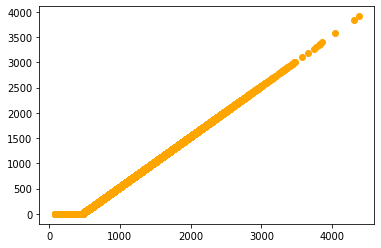

In [13]:
# Generate scatter plot for Call Options.
plt.scatter(st, ct, color='orange')

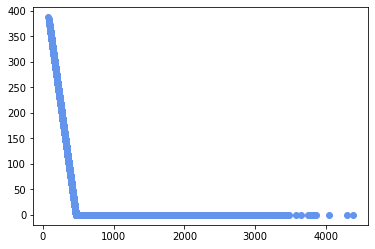

In [14]:
# Generate scatter plot for Put Options.
plt.scatter(st, pt, color='cornflowerblue')

### Call Option Simulation Statistics

In [15]:
call_lowcorr_avg = np.mean(ct)
print(f'Average call option pricing for low correlation stocks: {call_lowcorr_avg:.4f}')
call_lowcorr_C0 = call_lowcorr_avg * np.exp(- r * T)
print(f'Call option C0 for low correlation stocks: {call_lowcorr_C0:.4f}')

Average call option pricing for low correlation stocks: 82.0048
Call option C0 for low correlation stocks: 79.9001


## Perform Linear Regression on Call Option

In [16]:
# Create linear regression object.
lr_model = linear_model.LinearRegression()

x = np.array(st_ind)
y = np.array(ct)

# Training for call options.
lr_model.fit(x, y)

# # Make fitting predictions.
# call_pred = lr_model.predict(x)
# print(len(st))

# plt.scatter(st, ct,  color='orange')
# # plt.plot(st, call_pred, linestyle=':')

print('Model Parameters:')
print('Intercept:', lr_model.intercept_)
print('Slope:', lr_model.coef_)
C0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
print(f'C0: {C0_linear_model:.4f}')

Model Parameters:
Intercept: -220.23721132961327
Slope: [0.00515687 0.09833986 0.08241148 0.18007595]
C0: 79.9679


### Generate Trendline

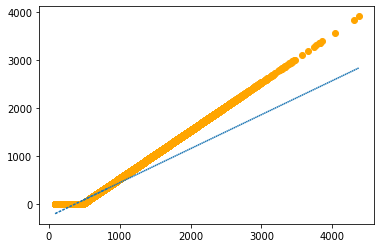

In [17]:
# Training for call options.
lr_model.fit(np.array(st).reshape((-1,1)), ct)

# Make fitting predictions.
call_pred = lr_model.predict(np.array(st).reshape((-1,1)))

plt.scatter(st, ct,  color='orange')
plt.plot(st, call_pred, linestyle=':')

## Put Option Statistics

In [18]:
put_lowcorr_avg = np.mean(pt)
print(f'Average put option pricing for low correlation stocks: {put_lowcorr_avg:.4f}')
put_lowcorr_C0 = put_lowcorr_avg * np.exp(- r * T)
print(f'Put option C0 for low correlation stocks: {put_lowcorr_C0:.4f}')

Average put option pricing for low correlation stocks: 69.8231
Put option C0 for low correlation stocks: 68.0311


## Perform Linear Regression on Call Option

In [19]:
# Create linear regression object.
lr_model = linear_model.LinearRegression()

x = np.array(st_ind)
y = np.array(pt)

# Training for call options.
lr_model.fit(x, y)

# # Make fitting predictions.
# put_pred = lr_model.predict(x)
# plt.scatter(st, pt,  color='cornflowerblue')
# plt.plot(st, put_pred, linestyle=':')

print('Model Parameters:')
print('Intercept:', lr_model.intercept_)
print('Slope:', lr_model.coef_)
P0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
print(f'P0: {P0_linear_model:.4f}')

Model Parameters:
Intercept: 245.95029057773343
Slope: [-0.24484313 -0.15166014 -0.16758852 -0.06992405]
P0: 68.0033


### Generate Trendline

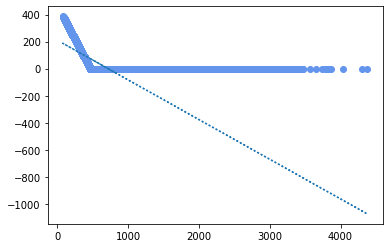

In [20]:
# Training for call options.
lr_model.fit(np.array(st).reshape((-1,1)), pt)

# Make fitting predictions.
put_pred = lr_model.predict(np.array(st).reshape((-1,1)))

plt.scatter(st, pt,  color='cornflowerblue')
plt.plot(st, put_pred, linestyle=':')

## Sensitivity Analysis

### Call VS Strike

In [21]:
call_strike = 300
num_simulations = 1000

call_strikes = np.zeros(20)
C0_call = np.zeros(20)

@njit(parallel=True, fastmath=True)
def simulation_strike(num_simulations, st, ct, pt, st_ind, strike):
        for i in prange(num_simulations):

            # Compute current spot stock price.
            stock_prices = spot_prices * np.exp((0.026 - 0.5 * sigmas ** 2) * T + cor_random_nums[i] * sigmas * np.sqrt(T))
            st_ind[i,:] = stock_prices
            st_basket = np.dot(stock_prices, W)
            st[i] = st_basket

            # Compute call price.
            ct[i] = max(st_basket - strike, 0)
            
            # Compute put price.
            pt[i] = max(strike - st_basket, 0)

for i in range(20):
    st = np.zeros(num_simulations) # stock prices
    ct = np.zeros(num_simulations) # call prices
    pt = np.zeros(num_simulations) # put prices
    st_ind = np.zeros((num_simulations, num_stocks)) # individual stock prices
    
    simulation_strike(num_simulations, st, ct, pt, st_ind, call_strike)
    
    # Create linear regression object.
    lr_model = linear_model.LinearRegression()

    x = np.array(st_ind)
    y = np.array(ct)

    # Training for call options.
    lr_model.fit(x, y)
    C0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
    
    C0_call[i] = C0_linear_model
    call_strikes[i] = call_strike
    
    call_strike += 20

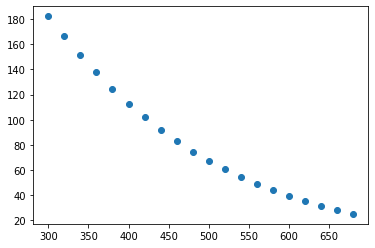

In [22]:
plt.scatter(call_strikes, C0_call)

In [23]:
call_vol = 0.0
num_simulations = 1000

call_vols = np.zeros(20)
C0_call = np.zeros(20)

@njit(parallel=True, fastmath=True)
def simulation_vol(num_simulations, st, ct, pt, st_ind, vol):
        for i in prange(num_simulations):

            # Compute current spot stock price.
            stock_prices = spot_prices * np.exp((0.026 - 0.5 * (sigmas + vol) ** 2) * T + cor_random_nums[i] * (sigmas + vol) * np.sqrt(T))
            st_ind[i,:] = stock_prices
            st_basket = np.dot(stock_prices, W)
            st[i] = st_basket

            # Compute call price.
            ct[i] = max(st_basket - strike, 0)
            
            # Compute put price.
            pt[i] = max(strike - st_basket, 0)
            
for i in range(20):
    st = np.zeros(num_simulations) # stock prices
    ct = np.zeros(num_simulations) # call prices
    pt = np.zeros(num_simulations) # put prices
    st_ind = np.zeros((num_simulations, num_stocks)) # individual stock prices
    
    simulation_vol(num_simulations, st, ct, pt, st_ind, call_vol)
    
    # Create linear regression object.
    lr_model = linear_model.LinearRegression()

    x = np.array(st_ind)
    y = np.array(ct)

    # Training for call options.
    lr_model.fit(x, y)
    C0_linear_model = (lr_model.intercept_ * np.exp(- 0.026 * T) + np.dot(lr_model.coef_, spot_df.values))[0]
    
    C0_call[i] = C0_linear_model
    call_vols[i] = call_vol
    
    call_vol += 0.2

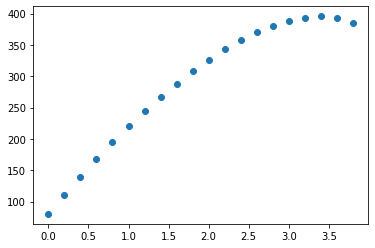

In [24]:
plt.scatter(call_vols, C0_call)